In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

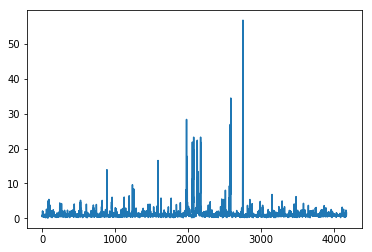

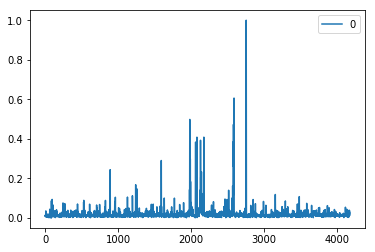

In [2]:
# loading data
col_names = ['time_stamp', 'numberOfTaskIndex', 'numberOfMachineId', 
             'meanCPUUsage', 'canonical_memory_usage', 'AssignMem',
             'unmapped_cache_usage', 'page_cache_usage', 'max_mem_usage',
             'mean_diskIO_time', 'mean_local_disk_space', 'max_cpu_usage',
             'max_disk_io_time', 'cpi', 'mai', 'sampling_portion',
             'agg_type', 'sampled_cpu_usage']
data = pd.read_csv('F:\LabDataAnalytics\data\google_trace_timeseries\data_resource_usage_10Minutes_6176858948.csv', header=None, names=col_names)
data = data.loc[:,'meanCPUUsage']
data.plot()
data = data.values

min_ = np.amin(data)
max_ = np.amax(data)

data = (data - min_) / (max_ - min_)

# mean = np.mean(data, axis=0)
# std = np.std(data, axis=0)

# data = (data - mean)/std
data = pd.DataFrame(data)
data.plot()

In [3]:
# split data to training set, validating set, testing set
def split_data(data, val_size=0.2, test_size=0.2):
    ntest = int(round(len(data) * (1 - test_size)))
    nval = int(round(len(data.iloc[:ntest]) * (1 - val_size)))
 
    df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest], data.iloc[ntest:]
 
    return df_train, df_val, df_test

# timeseries to suppervised learning
def series_to_suppervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n...t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1,...t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with Nan values
    if(dropnan):
        agg.dropna(inplace=True)
    return agg

In [8]:
# split data
train_set, val_set, test_set = split_data(data)

train_set = series_to_suppervised(train_set)
val_set = series_to_suppervised(val_set)
test_set = series_to_suppervised(test_set)

print(val_set.head())

x_train, y_train = train_set.iloc[:, 0].values, train_set.iloc[:, 1].values
x_val, y_val = val_set.iloc[:, 0].values, val_set.iloc[:, 1].values
x_test, y_test = test_set.iloc[:, 0].values, test_set.iloc[:, 1].values

# x_test = x_test * (max_ - min_) + min_
y_test = y_test * (max_ - min_) + min_

x_train = x_train.reshape([x_train.shape[0],1])
x_val = x_val.reshape([x_val.shape[0],1])
x_test = x_test.reshape([x_test.shape[0],1])




      var1(t-1)   var1(t)
2674   0.010805  0.013803
2675   0.013803  0.012024
2676   0.012024  0.013874
2677   0.013874  0.014187
2678   0.014187  0.008868


In [28]:
# build the model
tf.reset_default_graph()
x = tf.placeholder(dtype=tf.float32, shape=[None,1])
y = tf.placeholder(dtype=tf.float32, shape=[None,])

layer1 = tf.layers.dense(inputs=x, units=8, activation=tf.nn.relu)
layer2 = tf.layers.dense(inputs=layer1, units=8, activation=tf.nn.relu)
output = tf.layers.dense(inputs=layer2, units=1)
# y_pred = tf.add(tf.matmul(output , tf.subtract(max_ , min_)) ,min)
loss = tf.reduce_mean(tf.squared_difference(name='square_loss', x=output, y=y))
optimizer = tf.train.AdamOptimizer().minimize(loss)

training_summary = tf.summary.scalar("training_loss", loss)
validation_summary = tf.summary.scalar("val_loss", loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('./log/ann/', sess.graph)
    
    for i in range(100):
        l_train, _, train_summ = sess.run([loss, optimizer, training_summary], feed_dict={x:x_train, y:y_train})
        l_val , val_summ = sess.run([loss, validation_summary], feed_dict={x:x_val, y:y_val})
        print('epoch #',i,'loss=',l_train, 'val_loss=', l_val)
        writer.add_summary(train_summ, i)
        writer.add_summary(val_summ, i)
        
    
    y_pred = sess.run(output, feed_dict={x:x_test})
#     y_pred = y_pred.eval()
    y_pred = y_pred * (max_ - min_) + min_
    loss_test = np.mean(np.abs(y_pred - y_test))
#     l_test = tf.reduce_mean(tf.squared_difference(x=y_pred, y=y))
    print('Test loss=', loss_test)

epoch # 0 loss= 0.0017523464 val_loss= 0.0045407237
epoch # 1 loss= 0.0015840173 val_loss= 0.004460166
epoch # 2 loss= 0.0014878351 val_loss= 0.0044337
epoch # 3 loss= 0.0014546094 val_loss= 0.0044442555
epoch # 4 loss= 0.0014638101 val_loss= 0.0044678166
epoch # 5 loss= 0.0014891917 val_loss= 0.0044821627
epoch # 6 loss= 0.0015080251 val_loss= 0.004477488
epoch # 7 loss= 0.001510018 val_loss= 0.004455853
epoch # 8 loss= 0.0014965218 val_loss= 0.0044248737
epoch # 9 loss= 0.001474678 val_loss= 0.0043928353
epoch # 10 loss= 0.0014522431 val_loss= 0.004366149
epoch # 11 loss= 0.0014350807 val_loss= 0.0043481905
epoch # 12 loss= 0.0014261168 val_loss= 0.004339188
epoch # 13 loss= 0.0014253673 val_loss= 0.004336558
epoch # 14 loss= 0.0014299072 val_loss= 0.004336448
epoch # 15 loss= 0.0014356163 val_loss= 0.0043353955
epoch # 16 loss= 0.001439118 val_loss= 0.0043314598
epoch # 17 loss= 0.0014384512 val_loss= 0.0043246318
epoch # 18 loss= 0.0014337325 val_loss= 0.004316349
epoch # 19 loss= 